## graph creation notebook

In [21]:
import matplotlib
from matplotlib import pyplot as plt
import glob
import os

import networkx as nx
import fiona
import geopandas as gpd
from shapely.geometry import Point, Polygon, shape
from shapely.geometry.multilinestring import MultiLineString
from shapely.geometry.linestring import LineString
from descartes.patch import PolygonPatch
import pandas as pd
import numpy as np

# some custom files
from img_helpers import get_all_images_in_folder, return_polygons
from helper_functions import getpolygons, make_single_string_object,drop_columns_and_add_one,check_order

# to display images inline
get_ipython().magic(u'matplotlib inline')



## some setup for directories paths etc

In [2]:
folder_polygons = 'D:/allegoria/topo_ortho/ING_processed_margo/moselle/'
# load csv of the images saved previously part
excelPaths = sorted(glob.glob(folder_polygons +'*/*.csv'))
csv_poly = getpolygons(excelPaths)
imagePaths = sorted(glob.glob(folder_polygons +'*/*img.png'))
check_order(imagePaths, excelPaths)
print("Saved csv polygons are loaded correctly there %d ."%(len(csv_poly)))


Check the folder correspondence! Error in the check order funtion
Saved csv polygons are loaded correctly there 6000 .


In [3]:
global_path = "D:/allegoria/datasets_alegoria/BD/BD_topo/moselle/BDTOPO_3-0_TOUSTHEMES_SHP_LAMB93_D057_2019-03-19/BDTOPO/1_DONNEES_LIVRAISON_2019-03-00260/BDT_3-0_SHP_LAMB93_D057-ED2019-03-19/"

## roads

In [4]:
# load all the shapely files related to ROADS
fp_road = global_path + "TRANSPORT/ROUTE_NUMEROTEE_OU_NOMMEE.shp"
fp_road_troncon = global_path + "TRANSPORT/TRONCON_DE_ROUTE.shp"
# Read file using gpd.read_file()
data_road = gpd.read_file(fp_road)
data_road_troncon =  gpd.read_file(fp_road_troncon)
frames = [data_road, data_road_troncon]
# make a single table with all the roads, not just a signle type
all_roads=  pd.concat(frames,ignore_index=True) 

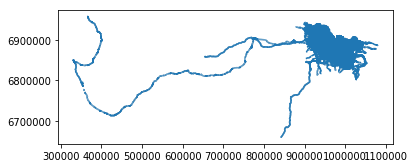

In [5]:
all_roads.plot()

## rivers

{'init': 'epsg:2154'}

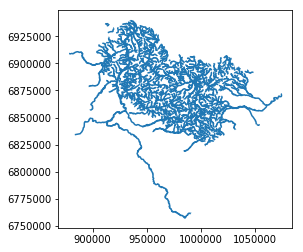

In [6]:
fp_water =  global_path + "HYDROGRAPHIE/COURS_D_EAU.shp"
data_water = gpd.read_file(fp_water)
# make a single table with all the roads, not just a signle type
all_water = data_water
all_water.plot()
len(all_water)
data_water.crs

## Main loop to save sub-shape files for each image
I go through the images and save the vector data inside their boundaries as shape files

In [22]:
# function to create a graph from pandas dataframe
from shapely.geometry.multilinestring import MultiLineString
def create_graph(gp_frame, poly = None):
    ''' function takes the pandas frame and creates the graph, where the nodes are the begining of the lines or
    crossiing points and links are the roads/rivers, the edges also have their nature information.
    Since sometimes the points can be outside of the polygon, one can also pass a polygon, so all the nodes outside of it 
    will be deleted:
    gp_frame = pandas dataframe with geometry column (supports geometry string)
    poly - polygon, all points outside of its coordinates will be deleted
    returns:
    Graph G, where are nodes are points, edges are types of element (nature=road 0 or water 1)
    Protocol: 
    1) Find start and end points of the lines
    2) Split lines at the intersections
    3) Create nodes at the start and end point of each split line and intersection points
    4) check with a polygon if the nodes are within the image borders. Remove if not.

    '''
    net = nx.Graph() # empty graph
    list_of_important_points = [] #empty list where I have the beginings of the line and the endings (start/end point) and crossing points
    #start + end points
    for shp in range(1, len(gp_frame)):
        # the geometry property here may be specific to my shapefile
        line = gp_frame['geometry'].iloc[shp] #get the line
        try:
            list_of_important_points.append([line.coords[0],line.coords[-1], gp_frame['Nature'].iloc[shp]]) #start, end, nature
        except:
            print('Not a line object encountered')
            
    # points crossings
    for shp in range(1, len(gp_frame)):
    # the geometry property here may be specific to my shapefile
        line1 = gp_frame['geometry'].iloc[shp] #get the line
        for shp2 in range(0, shp-1):
            line2 = gp_frame['geometry'].iloc[shp2] #get the second line
            if line1.intersects(line2):
                coordinates = line1.intersection(line2)
                if isinstance(coordinates, MultiLineString) or isinstance(coordinates, LineString):
                    pass
                else:    
                    try:
                        num_crossings = len(coordinates)
                        for c in range(num_crossings):
                            #then we have c  new edges - two crossed lines are divided into 4 parts
                            list_of_important_points.append([line1.coords[0],(coordinates[c].x,coordinates[c].y),gp_frame['Nature'].iloc[shp]]) #start, end, nature
                            list_of_important_points.append([line1.coords[-1],(coordinates[c].x,coordinates[c].y),gp_frame['Nature'].iloc[shp]]) #start, end, nature
                            list_of_important_points.append([line2.coords[0],(coordinates[c].x,coordinates[c].y),gp_frame['Nature'].iloc[shp2]]) #start, end, nature
                            list_of_important_points.append([line2.coords[-1],(coordinates[c].x,coordinates[c].y),gp_frame['Nature'].iloc[shp2]]) #start, end, nature
                    except:
                        list_of_important_points.append([line1.coords[0],(coordinates.x,coordinates.y),gp_frame['Nature'].iloc[shp]]) #start, end, nature
                        list_of_important_points.append([line1.coords[-1],(coordinates.x,coordinates.y),gp_frame['Nature'].iloc[shp]]) #start, end, nature
                        list_of_important_points.append([line2.coords[0],(coordinates.x,coordinates.y),gp_frame['Nature'].iloc[shp2]]) #start, end, nature
                        list_of_important_points.append([line2.coords[-1],(coordinates.x,coordinates.y),gp_frame['Nature'].iloc[shp2]]) #start, end, nature

    # not create a graph from an edgelist
    for edge in list_of_important_points:
        if poly is not None:
            if poly.contains(Point(edge[0])) and poly.contains(Point(edge[1])):
                net.add_edge(edge[0], edge[1],  nature = edge[2]) #add edge with weight, where weight is the nature
            else:
                continue
            
        else:
            net.add_edge(edge[0], edge[1],  nature = edge[2]) #add edge with weight, where weight is the nature
    return net


In [23]:
for i, poly in enumerate(csv_poly[25:26]):
    i=25
    name  = imagePaths[i][:-7] + 'vector.shp'
    print(name)
    sg_roads = all_roads[all_roads.geometry.intersects(poly)]  # extract segments of roads
    sg_water = all_water[all_water.geometry.intersects(poly)]  # extract segments of water
    sg_single_roads = make_single_string_object(sg_roads) # remove multistrings
    sg_single_water = make_single_string_object(sg_water)
    sg_single_roads = drop_columns_and_add_one(sg_single_roads, 'roads') # remove extra columns
    sg_single_water = drop_columns_and_add_one(sg_single_water, 'water')
    combined_pd = sg_single_roads.append(sg_single_water, ignore_index= True) # in this stage I am ready to save all the sub-images
    if combined_pd.empty:
        continue
    else:
        G = create_graph(gp_frame=combined_pd, poly=poly)


D:/allegoria/topo_ortho/ING_processed_margo/moselle\57-2015-0915-6905-LA93-0M50-E080\0000_vector.shp
MULTILINESTRING ((917150.3 6883616.1, 917148.9 6883605.1, 917146.7 6883586.5), (917150.3 6883616.1, 917139.5 6883612.2, 917130.3 6883608), (917158.5 6883653.7, 917156 6883634.9, 917152.7 6883623.1, 917150.3 6883616.1), (917145.7 6883699.7, 917149.6 6883690.7), (917142.9 6883706.3, 917145.7 6883699.7), (917156.8 6883668.2, 917157.4 6883666.2, 917158.5 6883653.7), (917149.6 6883690.7, 917152.2 6883684.4, 917156.8 6883668.2), (917073.5 6883857.8, 917086.3 6883823.2, 917095.7 6883801.5, 917104.8 6883784.8), (917063.1 6883884, 917072.4 6883860.8, 917073.5 6883857.8), (916645.3 6885089.8, 916642.4 6885051.4, 916640.9 6885015.4, 916641.5 6884983.6, 916641.9 6884974.5), (916657.4 6885262.6, 916655.9 6885238.7, 916653.2 6885201.7, 916649.6 6885150.5, 916645.9 6885098.1, 916645.3 6885089.8), (916917.2 6884344.6, 916924.6 6884325.5, 916942.3 6884278.6, 916946.9 6884266.2, 916955.4 6884237.5, 91696

In [24]:
# some verifications about the graph data type
G.edges(data=True)

EdgeDataView([((915366.6, 6900109.6), (915421.7, 6900155.2), {'nature': 0}), ((915366.6, 6900109.6), (915366.6, 6900109.6), {'nature': 0}), ((915366.6, 6900109.6), (915404.5, 6900055.2, 252.4), {'nature': 0}), ((915366.6, 6900109.6), (915366.6, 6900109.6, 255.3), {'nature': 0}), ((915366.6, 6900109.6), (915421.7, 6900155.2, 257.9), {'nature': 0}), ((915366.6, 6900109.6), (915354.4, 6900124.6, 254.8), {'nature': 0}), ((915421.7, 6900155.2), (915750.2, 6900513.7), {'nature': 0}), ((915421.7, 6900155.2), (915421.7, 6900155.2, 257.9), {'nature': 0}), ((915421.7, 6900155.2), (915750.2, 6900513.7, 262.8), {'nature': 0}), ((915421.7, 6900155.2), (915421.7, 6900155.2), {'nature': 0}), ((915421.7, 6900155.2), (915404.5, 6900055.2, 252.4), {'nature': 0}), ((915421.7, 6900155.2), (915366.6, 6900109.6, 255.3), {'nature': 0}), ((915750.2, 6900513.7), (915840.9, 6900882.4), {'nature': 0}), ((915750.2, 6900513.7), (915750.2, 6900513.7), {'nature': 0}), ((915750.2, 6900513.7), (915421.7, 6900155.2, 25

In [16]:
type(sg_single_water['geometry'].loc[0])

shapely.geometry.linestring.LineString

## Segment -> Graph -> Visualization
This part of the notebook plots my graphs and vector files to show that the graph was made correctly

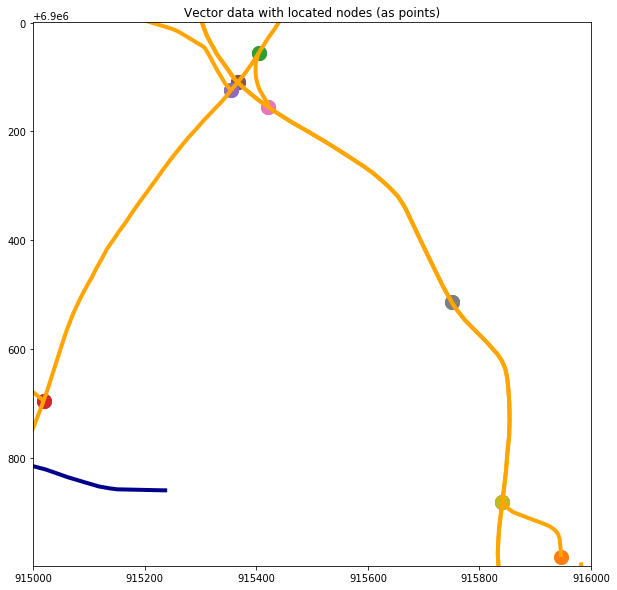

In [25]:
# check if the nodes are correctly extracted
for poly in csv_poly[25:26]:    
    sg_roads = all_roads[all_roads.geometry.intersects(poly)]  # extract segments of roads
    sg_water = all_water[all_water.geometry.intersects(poly)]  # extract segments of water
    fig, ax = plt.subplots(figsize=(10.0, 10.0))
    if not  sg_roads.empty:
        sg_roads.plot(linewidth=4.0, edgecolor='#FFA500', color='#FFA500', ax=ax)
    if not sg_water.empty:
        sg_water.plot(linewidth=4.0, edgecolor='#00008B', color='#00008B', ax=ax)
    for n in G.nodes:      
        ax.scatter(n[0],n[1], marker="o", s=200, label=str(i))
    ax.set_xlim([poly.bounds[0],poly.bounds[2]])
    ax.set_ylim([poly.bounds[3],poly.bounds[1]])
    ax.set_title("Vector data with located nodes (as points)")


In [ ]:
## convert to indirected G.to_indirected or view (below)

15

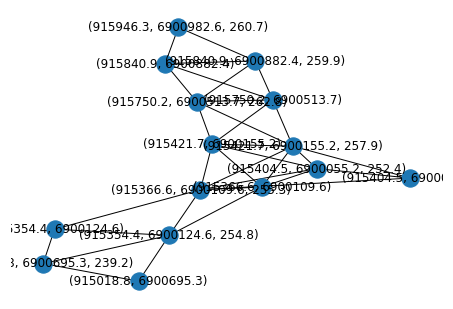

In [26]:
nx.draw(G, with_labels = True)
len(G)

In [208]:
G.degree

DegreeView({(915757.7, 6893954.8): 5, (915827.0, 6893957.5): 4, (915703.1, 6893950.1): 4, (915666.8, 6893947.4): 4, (915811.4, 6893983.8): 4, (915753.0, 6893983.8): 4, (915535.7, 6893945.2): 3, (915610.4, 6893945.5): 4, (915027.5, 6893163.2): 4, (915036.6, 6893106.7): 3, (915910.6, 6893303.5): 3, (915679.5, 6893200.3): 5, (915019.0, 6893547.9): 5, (915019.5, 6893667.3): 4, (915409.4, 6893641.6): 6, (915700.8, 6893054.1): 4, (915935.6, 6893125.0): 1, (915332.2, 6893909.9): 4, (915932.7, 6893728.1): 2, (915380.2, 6893729.0): 3})

In [207]:
G.adjacency

<bound method Graph.adjacency of <networkx.classes.graph.Graph object at 0x000001B1B9A10908>>